In [1]:
import pandas as pd
import numpy as np

In [2]:
base = "/Users/lucreziavaleriani/Desktop/orfeo_scratch/utils_locate/simulations_rRACES/out/clonal/sim_21/cov_70_p_0.9"
data = pd.read_csv(base + "/mirr_smooth_snv.csv", sep = ',', on_bad_lines='skip') 

data['pos'] = range(1, len(data) + 1)
data['median_baf'] = data['median_baf'].apply(lambda x: 1 - x if x > 0.5 else x)
data = data[data['median_baf']>0]

tmp_csv = base + '/tmp.csv'
test_df = pd.DataFrame({"baf":data.median_baf, "dr":data.median_dr, "pos":data.pos, 'vaf':data.vaf})
test_df.to_csv(path_or_buf=tmp_csv, sep=",")

In [3]:
from locate.segmentation.multivariate_clasp import MultivariateClaSP

In [10]:
thr = 1e-15
w_size = 5
md = 'max'

multiClasp = MultivariateClaSP(tmp_csv, 
                               mode=md, #max
                               out_dir=base, 
                               threshold=thr, 
                               window_size=w_size,
                               cna_id = None,
                               frequencies = ['baf', 'dr', 'vaf'])

In [12]:
multiClasp.analyze_time_series()

(<Figure size 1000x800 with 3 Axes>,
 array([<Axes: ylabel='BAF'>, <Axes: ylabel='DR'>,
        <Axes: xlabel='Position', ylabel='VAF'>], dtype=object))

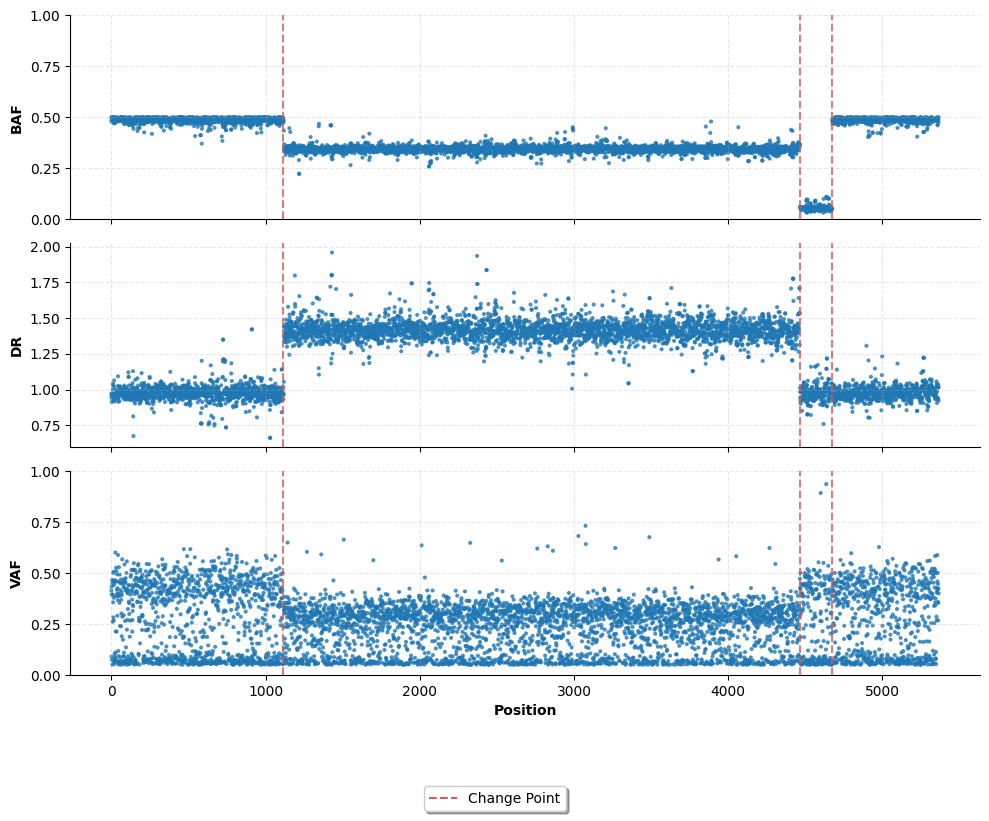

In [6]:
multiClasp.plot_results(save=True)

In [35]:
def coalesce_equal_cn(df):
    """
    Merge consecutive rows with the same CN (and contiguous coordinates).
    Returns a new coalesced dataframe.
    """
    if df.empty:
        return df.copy()

    rows = []
    cur_cn = df.iloc[0].CN
    cur_start = int(df.iloc[0].start)
    cur_end = int(df.iloc[0].end)

    for i in range(1, len(df)):
        row = df.iloc[i]
        if (row.CN == cur_cn) and (int(row.start) == cur_end + 1):
            # extend current block
            cur_end = int(row.end)
        else:
            rows.append({"CN": cur_cn, "start": cur_start, "end": cur_end})
            cur_cn = row.CN
            cur_start = int(row.start)
            cur_end = int(row.end)
    rows.append({"CN": cur_cn, "start": cur_start, "end": cur_end})
    return pd.DataFrame(rows)


def greedy_match(true_bps, pred_bps, tol):
    """
    One-to-one greedy matching by smallest distance under tolerance.
    Returns arrays of matched indices and distances.
    """
    if len(true_bps) == 0 or len(pred_bps) == 0:
        return [], [], []

    pairs = []
    for ti, t in enumerate(true_bps):
        for pi, p in enumerate(pred_bps):
            d = abs(int(t) - int(p))
            if d <= tol:
                pairs.append((d, ti, pi))
    # sort by distance, then match greedily
    pairs.sort(key=lambda x: x[0])
    used_true = set()
    used_pred = set()
    matches = []
    for d, ti, pi in pairs:
        if ti not in used_true and pi not in used_pred:
            used_true.add(ti)
            used_pred.add(pi)
            matches.append((ti, pi, d))

    matched_true_idx = [m[0] for m in matches]
    matched_pred_idx = [m[1] for m in matches]
    dists = [m[2] for m in matches]

    return matched_true_idx, matched_pred_idx, dists


def evaluate_segmentation(run_id, df_true, pred_bps, tolerance=10, merge_equal_cn=True):
    """
    Evaluate predicted breakpoints against ground truth.
    - Optionally merges consecutive equal-CN segments in the ground truth.
    - Penalizes extra breakpoints inside constant-CN runs.
    """
    # 1) Coalesce ground truth if requested
    df_eval = coalesce_equal_cn(df_true) if merge_equal_cn else df_true.copy()

    # 2) True breakpoints after coalescing = ends except the very last end
    true_bps = df_eval["end"].iloc[:-1].astype(int).values

    pred_bps = np.sort(np.asarray(pred_bps, dtype=int))

    # 3) Greedy one-to-one matching under tolerance
    t_idx, p_idx, dists = greedy_match(true_bps, pred_bps, tolerance)

    # 4) Compute standard metrics (TP/FP/FN)
    TP = len(p_idx)
    FP = len(pred_bps) - TP
    FN = len(true_bps) - TP

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    mean_abs_error = float(np.mean(dists)) if len(dists) else None
    max_abs_error = int(np.max(dists)) if len(dists) else None

    # 5) Flag "unnecessary splits": predicted bps that fall strictly inside a single coalesced segment
    #    and are farther than tolerance from any true bp.
    #    (Equivalent to unmatched predicted bps where position is not near any true boundary)
    unnecessary = []
    for i, p in enumerate(pred_bps):
        if i in p_idx:
            continue  # matched, not unnecessary
        # check nearest true bp distance
        if len(true_bps):
            nearest = int(np.min(np.abs(true_bps - p)))
        else:
            nearest = np.inf

        # check if p lies inside exactly one coalesced segment
        in_segment = False
        for _, r in df_eval.iterrows():
            if r.start <= p <= r.end:
                in_segment = True
                break
        if in_segment and (nearest > tolerance):
            unnecessary.append(int(p))

    results = {
        "used_tolerance_bp": tolerance,
        "merged_ground_truth": merge_equal_cn,
        "n_true_breakpoints": int(len(true_bps)),
        "n_pred_breakpoints": int(len(pred_bps)),
        "TP": int(TP),
        "FP": int(FP),
        "FN": int(FN),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "mean_abs_error_on_matched": mean_abs_error,
        "max_abs_error_on_matched": max_abs_error,
        "unnecessary_splits": unnecessary,
        "coalesced_truth_df": df_eval,
        "true_breakpoints_after_merge": true_bps
    }
    
    row = {
        "run_id": run_id,
        "tolerance": results["used_tolerance_bp"],
        # "merged_truth": results["merged_ground_truth"],
        "n_true_bps": results["n_true_breakpoints"],
        "n_pred_bps": results["n_pred_breakpoints"],
        "TP": results["TP"],
        "FP": results["FP"],
        "FN": results["FN"],
        "precision": results["precision"],
        "recall": results["recall"],
        "f1": results["f1"],
        "mean_abs_error": results["mean_abs_error_on_matched"],
        "max_abs_error": results["max_abs_error_on_matched"],
        # "unnecessary_splits": results["unnecessary_splits"],
        "true_breakpoints": results["true_breakpoints_after_merge"].tolist(),
    }
    return pd.DataFrame([row])



In [36]:
real_bp = pd.read_csv(base + "/mirr_smooth_bps.csv", sep = ',', on_bad_lines='skip') 
inferred_bp = np.load(base+'/max_5_1e-15.npy')

In [ ]:
metrics = evaluate_segmentation('sim_21', real_bp, inferred_bp, tolerance=10)

,run_id,tolerance,n_true_bps,n_pred_bps,TP,FP,FN,precision,recall,f1,mean_abs_error,max_abs_error,true_breakpoints
0,sim_21,10,3,3,3,0,0,1.0,1.0,1.0,2.666667,4,"[1119, 4466, 4675]"
